# 02 - Kernel methods and SVMs
** Ecole Centrale Nantes **

** Diana Mateus **





PARTICIPANTS: Charles GIRARD - Saâd AZIZ ALAOUI

    

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import random


from skimage.color import rgb2gray
from skimage.transform import resize

from sklearn.svm import SVC
from sklearn.utils import shuffle


from sklearn.metrics import f1_score 
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# 1. Image classification on Caltech 101

**a)** Download images from
http://www.vision.caltech.edu/feifeili/Datasets.htm
and run the code bellow to check the files and store the name of the classes in the list ```labelNamesAll```

(Just run)

In [3]:
## VERIFY LOCATION AND STORE LABEL NAMES

#IMDIR = '101Caltech/101_ObjectCategories/'
IMDIR = 'C:/Users/saada/OneDrive/Bureau/Etudes/APSTA/TP2/caltech-101/101_ObjectCategories'


labelNamesAll = []

for root, dirnames, filenames in os.walk(IMDIR):
    labelNamesAll.append(dirnames)
    #uncomment to check what is found in this folder
    #for filename in filenames:
        #f = os.path.join(root, filename)
        #if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
        #    print(f)

labelNamesAll = labelNamesAll[0]

#The list of all labels/directories is
print(labelNamesAll)

['accordion', 'airplanes', 'anchor', 'ant', 'BACKGROUND_Google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'Faces', 'Faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'Leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'Motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 's

**b. Build a reduced dataset for accelerating process.** To do so: 
- Consider only up to $K$ randomly drawn categories (start with a binary case)
- Read only up to $N$ images for each class
- Resize the images to $(imWidth*imHeight)$

The dataset should consist of a 
- Input matrix $\mathbf{X}$ of size $(K\cdot N)\times (imWidth\cdot imHeight)$ with one image in every row of the matrix. 
- Output vector $\mathbf{y}$ of size $(K\cdot N)\times 1$ with the label index of each input point in $\bf X$.
- the reduced list of the label names of size $K$ to map between the indices and the names.

**Note than different classes may have different number of images so that the actual number of $\bf X$ and $\bf y$ is less than $K*N$**

(Run and try to understand the structure of the data)

In [4]:
#build DATASET from K categories and (up to) N images from category
K = 2 
N = 800
imWidth = 100 #resize images
imHeight = 100

#selection of label indices
X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
#Y = np.zeros([K*N,1]) #label indices
Y = -np.ones([K*N,1]) #label indices
labelNames = []

random.seed(a=15) #uncomment to make errors reproducible/comment to see variability

globalCount = 0
for i in range(K): 
    while True:
        lab = random.randint(0,len(labelNamesAll)-1)
        if lab not in labelNames:
            break
    #folders are named after the class label
    filedir = os.path.join(IMDIR,labelNamesAll[lab])
    print(filedir)

    #save the name of the class
    labelNames.append(labelNamesAll[lab])       

    classCount = 0
    for filename in os.listdir(filedir):
        f = os.path.join(filedir, filename)
        if f.endswith(('.jpg')) and (classCount < N):
            #image = skimage.io.imread(f, as_grey=True) #Try this line instead of the one below if there is an error
            image = skimage.io.imread(f, as_gray=True)
            image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
            X[globalCount,:] = image.flatten()
            Y[globalCount,:] = i
            globalCount += 1
            classCount += 1

#Remove the unused entries of X and Y
print("Total number of samples",globalCount)
X = X[:globalCount,:]
Y = Y[:globalCount,:]

#Check the stored classes
print("used labels",labelNames)
print("Size of data matrix", X.shape)
print("clas labels", Y.T)



C:/Users/saada/OneDrive/Bureau/Etudes/APSTA/TP2/caltech-101/101_ObjectCategories\crocodile_head
C:/Users/saada/OneDrive/Bureau/Etudes/APSTA/TP2/caltech-101/101_ObjectCategories\airplanes
Total number of samples 851
used labels ['crocodile_head', 'airplanes']
Size of data matrix (851, 10000)
clas labels [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1

**c**. Split the dataset into train (80% of samples) and test (20% samples). 
(Run and try to understand the structure of the data)

In [5]:
# Split in Train and test set with 80% - 20% rule

Ntrain = np.rint(.8*Y.shape[0]).astype(int)
Ntest = Y.shape[0]-Ntrain
print('Training with', Ntrain , 'training samples and ', Ntest, 'testing samples.')

# Randomize the order of X and Y
X, Y = shuffle(X, Y, random_state=0)

print(Y.shape)
# Split the data and labels into training/testing sets
X_train = X[0:Ntrain,:]
Y_train = Y[0:Ntrain,:]
print(Y_train.shape)
X_test = X[Ntrain:,:]
Y_test = Y[Ntrain:,:]

print("size of train dataset",X_train.shape)
print("size of test dataset",X_test.shape)
print("train target vector",Y_train.T)
print("test target vector",Y_test.T)

Training with 681 training samples and  170 testing samples.
(851, 1)
(681, 1)
size of train dataset (681, 10000)
size of test dataset (170, 10000)
train target vector [[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
  1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
  1. 1. 1. 1. 1. 1

**d) Training and testing a SVM
- Create an SVC model using the sklearn module, 
- train it on the train set, 
- and test it on the test set**. 

(Fill in the code and answer the questions)

**Question** SVMs are intrinsically binary classifiers, can you train the SVC for K>2? How is that achieved?

**ANSWER**: Fill your answer here

In [6]:
# Create, train and test an svm model using the sklearn SVC

clf = SVC(kernel='rbf')

clf.fit(X_train, Y_train.ravel())

Y_pred = clf.predict(X_test)

# FILL YOUR CODE HERE 


print("True classes",Y_test.T)
print("Predictions",Y_pred)
errors = np.sum((Y_test.ravel()!=Y_pred))
print('There were ', errors, 'errors')

True classes [[1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
  1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1.]]
Predictions [1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.

**e) Fill in the functions bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix, and the values TP, TN, FP, FN, for a binary case. When considering multiple clases ($K>2$) treat one class at a time as the postive class, and the remaining classes as negative. You may want to indicate the positive class as a parameter to the indicator function.

**Question:** There are three ways of resuming the scores for a multiple class problem $K>2$, namely, the macroaverage, the microaverage and the weighted average. Implement and EXPLAIN them below.

**Hint** Add a numerical zero eps to the denominators to prevent dividing by zero

**Hint2** for the multi-class case:

https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin.

**ANSWER** 

- MACRO-AVERAGE : Calcule la moyenne des scores de chaque classe. Cette méthode évalue de manière très globale les performances du classifieur.
- MICRO-AVERAGE : Cette méthode estime que toutes les classes n'en représentent qu'une seule et caclcule de fait les scores.
- WEIGHTED-AVERAGE : Cette méthode vient utiliser l'influence dans le dataset des données de précision. Elle calcule donc ces dernières en moyennant les valeurs selon leur importance.

In [19]:
# Functions to compute the errors between prediction and ground truth 

from sklearn.metrics import confusion_matrix

def compute_measures(Y_gt,Y_pred, positiveClass=1): #Y_gt = ground truth
    measures = dict()
    Y_len = len(Y_gt)
    
    measures['positivClass'] = positiveClass
    measures["sizeSample"] = Y_len
    
    eps = 1e-12
    # True positives TP
    TP = 0
    for i in range(len(Y_gt)):
        if Y_gt[i] == 1 and Y_pred[i] == 1:
            TP += 1
        
    # True negatives TN
    TN = 0
    for i in range(len(Y_gt)):
        if Y_gt[i] == 0 and Y_pred[i] == 0:
            TN += 1
            
    # False positives FP
    FP = 0
    for i in range(len(Y_gt)):
        if Y_gt[i] == 0 and Y_pred[i] == 1:
            FP += 1
        
    # False negatives FN
    FN = 0
    for i in range(len(Y_gt)):
        if Y_gt[i] == 1 and Y_pred[i] == 0:
            FN += 1
    
    print('TP ', TP, 'TN ', TN, 'FP', FP, 'FN', FN, 'Total', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN
    
    
    # Accuracy
    measures['accuracy'] = (TP+TN)/(TP+TN+FP+FN)
    
    # Precision
    measures['precision'] = TP/(TP+FP+eps)
        
    # Specificity
    measures['specificity']= TN/(TN+FP+eps)
    
    # Recall
    measures['recall'] = TP/(TP+FN+eps)
    
    # F-measure
    measures['f1'] = 2*TP/(2*TP+FP+FN+eps) 
    
    # Negative Predictive Value
    measures['npv'] = TN/(TN+FN+eps)
    
    # False Predictive Value
    measures['fpr'] = FP/(FP+TN+eps)
    
    print('--------------Measures----------------' , '\n')
    print('Accuracy ', measures['accuracy'], '\n',
          'Precision', measures['precision'], '\n',
          'Recall', measures['recall'], '\n',
          'Specificity ', measures['specificity'], '\n',
          'F-measure', measures['f1'], '\n',
          'NPV', measures['npv'],'\n',
          'FPV', measures['fpr'],'\n') 
    return measures

def micro_average(measuresList):
    microAverage = dict()
    eps = 1e-12
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(measuresList)):
        TP = TP + measuresList[i]['TP']
        TN = TN + measuresList[i]['TN']
        FP = FP + measuresList[i]['FP']
        FN = FN + measuresList[i]['FN']
    
    # Accuracy
    microAverage['accuracy'] = (TP+TN)/(TP+TN+FP+FN+eps)
    
    # Precision
    microAverage['precision'] = TP/(TP+FP+eps)
        
    # Specificity
    microAverage['specificity'] = TN/(FP+TN+eps)
    
    # Recall
    microAverage['recall'] = TP/(TP+FN+eps)
    
    # F-measure
    microAverage['f1'] = 2*TP/(2*TP+FP+FN+eps)
    
    # Negative Predictive Value
    microAverage['npv'] = TN/(TN+FN+eps)
    
    # False Predictive Value
    microAverage['fpr'] = FP/(FP+TN+eps)
    
    print('------------MICRO--------------' , '\n')           
    print('Accuracy ', microAverage['accuracy'], '\n',
          'Precision', microAverage['precision'], '\n',
          'Recall', microAverage['recall'], '\n',
          'Specificity ', microAverage['specificity'], '\n',
          'F-measure', microAverage['f1'], '\n',
          'NPV', microAverage['npv'],'\n',
          'FPV', microAverage['fpr'],'\n')
    
    return microAverage

def macro_average(measuresList):
    macroAverage = dict()
    accu = 0
    preci = 0
    speci = 0
    recall = 0
    f = 0
    np = 0
    fp = 0
    
    n = len(measuresList)
    
    for i in range(n):
        accu += measuresList[i]['accuracy']
        preci += measuresList[i]['precision']
        speci += measuresList[i]['specificity']
        recall += measuresList[i]['recall']
        f += measuresList[i]['f1']
        np += measuresList[i]['npv']
        fp += measuresList[i]['fpr']
        
    # Accuracy
    macroAverage['accuracy'] = accu/n
    
    # Precision
    macroAverage['precision'] = preci/n
        
    # Specificity
    macroAverage['specificity']= speci/n
    
    # Recall
    macroAverage['recall'] = recall/n
    
    # F-measure
    macroAverage['f1'] = f/n
    
    # Negative Predictive Value
    macroAverage['npv'] = np/n
    
    # False Predictive Value
    macroAverage['fpr'] = fp/n
    print('------------MACRO----------------' , '\n')      
    print('Accuracy ', macroAverage['accuracy'], '\n',
          'Precision', macroAverage['precision'], '\n',
          'Recall', macroAverage['recall'], '\n',
          'Specificity ', macroAverage['specificity'], '\n',
          'F-measure', macroAverage['f1'], '\n',
          'NPV', macroAverage['npv'],'\n',
          'FPV', macroAverage['fpr'],'\n')
    
    return macroAverage

def weighted_average(measuresList):
    weightedAverage = dict()
    N=len(measuresList)
    
    
    TP = [measure['TP'] for measure in measuresList]
    FP = [measure['FP'] for measure in measuresList]
    TN = [measure['TN'] for measure in measuresList]
    FN = [measure['FN'] for measure in measuresList]
    
    precision = [measure['precision'] for measure in measuresList]
    recall = [measure['recall'] for measure in measuresList]
    specificity = [measure['specificity'] for measure in measuresList]
    accuracy = [measure['accuracy'] for measure in measuresList]
    npv = [measure['npv'] for measure in measuresList]
    fpr = [measure['fpr'] for measure in measuresList]
    y_len = [measure['sizeSample'] for measure in measuresList]
    weightedAverage['accuracy']=0
    weightedAverage['precision']=0
    weightedAverage['specificity']=0
    weightedAverage['recall']=0
    weightedAverage['f1']=0
    weightedAverage['npv']=0
    weightedAverage['fpr']=0
    
    for i in range(N):
        # Accuracy
        support=TP[i]+FN[i]
        weightedAverage['accuracy'] += accuracy[i]*support/y_len[i]

        # Precision
        weightedAverage['precision']+= precision[i]*support/y_len[i]
        
        # Specificity
        weightedAverage['specificity']+= specificity[i]*support/y_len[i]

        # Recall
        weightedAverage['recall'] += recall[i]*support/y_len[i]

        # F-measure
        weightedAverage['f1'] += measuresList[i]['f1']*support/y_len[i]

        # Negative Predictive Value
        weightedAverage['npv'] += npv[i]*support/y_len[i]

        # False Predictive Value
        weightedAverage['fpr'] += fpr[i]*support/y_len[i]
        
    print("------ WEIGHTED---------")
    print('Accuracy ', weightedAverage['accuracy'], '\n',
          'Precision', weightedAverage['precision'], '\n',
          'Recall', weightedAverage['recall'], '\n',
          'Specificity ', weightedAverage['specificity'], '\n',
          'F-measure', weightedAverage['f1'], '\n',
          'NPV', weightedAverage['npv'],'\n',
          'FPV', weightedAverage['fpr'],'\n')
    

**e)** Measure the performance of the SVC model for multiple classes $K>2$

First collect the measures when considering each class as positive, then, compute macro and microaverage 

Compare your results to those of sklearn metrics. 

In [20]:
#Fill in a list of measure dictionaries taking as input a different positive class

multiclass = []
for k in range(K):
    print('For class',labelNames[k])
    multiclass.append(compute_measures(Y_test.ravel(),Y_pred, positiveClass=k))

print('Macro-average')
macro_average(multiclass)
    
print('Micro-average')
micro_average(multiclass)

print('Weighted-average')
weighted_average(multiclass)


from sklearn.metrics import classification_report #confusion_matrix, accuracy_score, precision_score, recall_score, f1_micro, f1_macro
print(classification_report(Y_test.ravel(), Y_pred, target_names=labelNames))

For class crocodile_head
TP  162 TN  1 FP 7 FN 0 Total 170
--------------Measures---------------- 

Accuracy  0.9588235294117647 
 Precision 0.9585798816567991 
 Recall 0.9999999999999939 
 Specificity  0.12499999999998437 
 F-measure 0.9788519637462205 
 NPV 0.9999999999989999 
 FPV 0.8749999999998906 

For class airplanes
TP  162 TN  1 FP 7 FN 0 Total 170
--------------Measures---------------- 

Accuracy  0.9588235294117647 
 Precision 0.9585798816567991 
 Recall 0.9999999999999939 
 Specificity  0.12499999999998437 
 F-measure 0.9788519637462205 
 NPV 0.9999999999989999 
 FPV 0.8749999999998906 

Macro-average
------------MACRO---------------- 

Accuracy  0.9588235294117647 
 Precision 0.9585798816567991 
 Recall 0.9999999999999939 
 Specificity  0.12499999999998437 
 F-measure 0.9788519637462205 
 NPV 0.9999999999989999 
 FPV 0.8749999999998906 

Micro-average
------------MICRO-------------- 

Accuracy  0.9588235294117619 
 Precision 0.9585798816568019 
 Recall 0.9999999999999969 


**f) Show the test images as well as the the predictions (Y_pred) vs the ground truth (Y_gt) labels for the best model**
(Just run for each analysed model)

ValueError: num must be 1 <= num <= 120, not 121

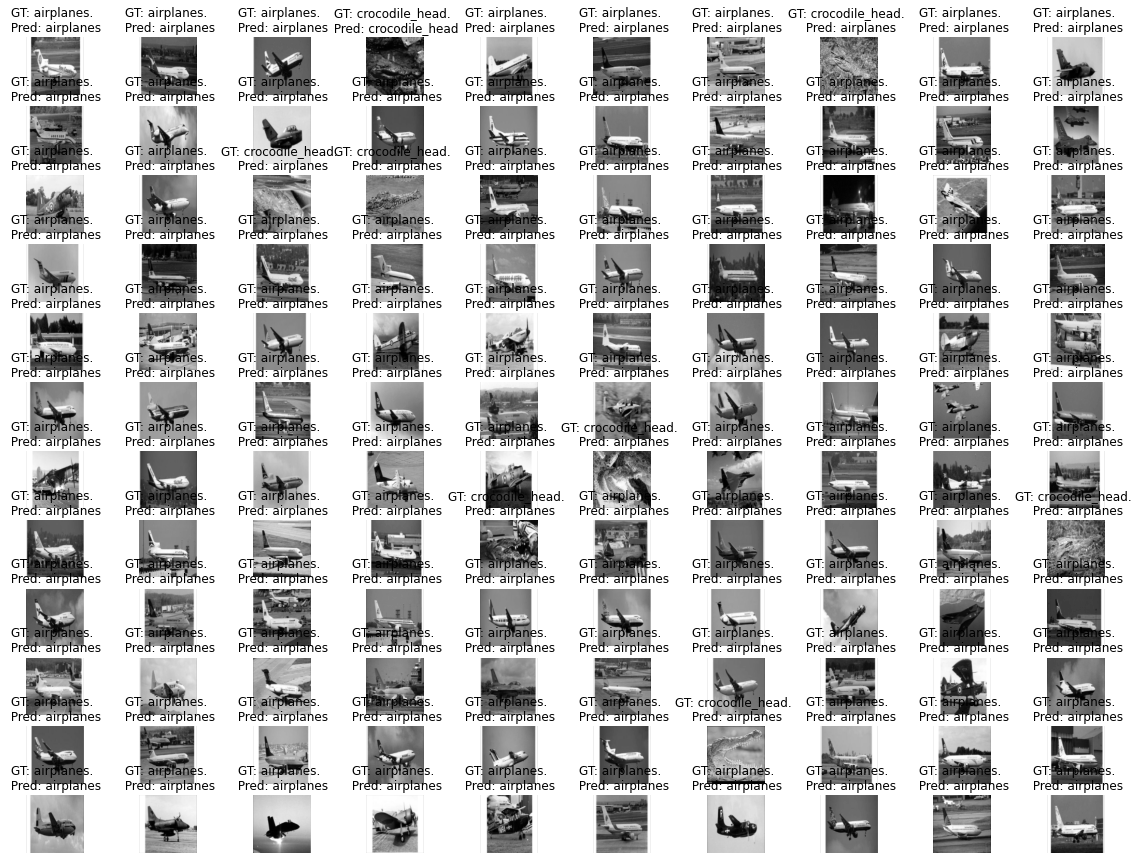

In [25]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]
fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth)) 

    plt.subplot(12,10,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_pred.ravel()[i].astype(int)]
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()


** g) REPORT:**  Change the kernel and other hyperparameters of your SVC trying to optimize the F1 measure for different cases. Describe in your report the different variants of the model tried. You may want to split your dataset into train, validation and test sets this time to find the best hyperparameters. Present and discuss your findings for different hyperparameters, number of classes and numbers of images. THIS IS THE MOST IMPORTANT PART FOR THE EVALUATION. 

On a utilisé différentes valeurs de nombres de classes et d'images par classes pour chercher les hyperparamètres optimaux. On observe tout d'abord que les valeurs optimales dépendent de la taille du dataset et du nombre de classes.
On observe également une différence entre les kernels " rbf , sigmoid, poly, linear. " 
De manière globale, on retient le fait que chaque changement de paramètre d'entrée influe sur le choix des hyperparamètres optimaux. Créer un bon pipeline de classification nécessite une réflexion profonde au début ainsi que de l'adaptation au fur et à mesure que le dataset change. Les pipeline ne sont pas figés dès qu'ils sont créés.

In [41]:
gam=np.array([1e-3,1e-2,1e-1,1,10,100,1000])
Cr=np.array([1e-3,1e-2,1e-1,1,10,100,1000])
F1=np.zeros([7,7])

def tuning(X,Y,gam,Cr):
    kf = KFold(5,True,10)
    
    for i in range (gam.shape[0]):
        for j in range (Cr.shape[0]):
            fscore=[]
            for m,n in kf.split(X):
                clf = SVC(C=Cr[j],kernel='poly',gamma=gam[i])  #'rbf','linear','poly','sigmoid'
                X_train,X_test = X[m],X[n];Y_train,Y_test = Y[m],Y[n]                
                clf.fit(X_train,Y_train.ravel())
                Y_pred=clf.predict(X_test)
                fscore.append(f1_score(Y_test.ravel(),Y_pred,average='macro'))
            F1[i,j]=np.mean(fscore)
            
    return(np.where(F1==np.max(F1))) 


In [ ]:
for K in [2,3,4,5]:
    for N in [10,30,50]:
        
        #build DATASET from K categories and (up to) N images from category
        imWidth = 100
        imHeight = 100

        #selection of label indices
        X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
        Y = -np.ones([K*N,1]) #label indices
        labelNames = []
        globalCount = 0
        
        for i in range(K):
            
            lab = random.randint(0,len(labelNamesAll)-1)
            #folders are named after the class label
            filedir = os.path.join(IMDIR,labelNamesAll[lab])
  
            #save the name of the class
            labelNames.append(labelNamesAll[lab])       
            classCount = 0
            for filename in os.listdir(filedir):
                f = os.path.join(filedir, filename)
        
                if f.endswith(('.jpg')) and (classCount < N):
                    image = skimage.io.imread(f, as_gray=True)
                    image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')
                    X[globalCount,:] = image.flatten();Y[globalCount,:] = i 
                    globalCount += 1;classCount += 1
        train_X,test_X,train_y,test_y=train_test_split(X,Y,test_size=0.2,random_state=5)
        [gamma,C]=tuning(train_X,train_y,gam,Cr)
  
        print('Best F1 measure with {} classes and {} images/class'.format(K,N))
        print('gamma=',gam[gamma[0]])
        print('C=',Cr[C[0]],'\n')


C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best F1 measure with 2 classes and 10 images/class
gamma= 0.001
C= 0.01 



C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best F1 measure with 2 classes and 30 images/class
gamma= 0.001
C= 1.0 



C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best F1 measure with 2 classes and 50 images/class
gamma= 0.001
C= 1.0 



C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best F1 measure with 3 classes and 10 images/class
gamma= 0.001
C= 1.0 



C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best F1 measure with 3 classes and 30 images/class
gamma= 0.001
C= 1.0 



C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best F1 measure with 3 classes and 50 images/class
gamma= 0.001
C= 0.1 



C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best F1 measure with 4 classes and 10 images/class
gamma= 0.001
C= 1.0 



C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


Best F1 measure with 4 classes and 30 images/class
gamma= 0.001
C= 10.0 



C:\Users\saada\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass shuffle=True, random_state=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
